In [1]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

import os
from os.path import join
import sys
from IPython.display import display
from PIL import Image

ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-2])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print(DATASET_DIR)

/home/djoy2409-wsl/projects/software_development/qsar_w_gnns/data


In [3]:
from typing import List, Union, Any, Tuple
from datetime import datetime
from random import sample

import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch_geometric
from torch_geometric.data import Data
from torch.nn import BCELoss, LeakyReLU, ReLU
from torch.optim import lr_scheduler,Adagrad, Adadelta, Adam, AdamW

from rdkit import Chem, RDLogger
from rdkit.Chem import Draw, AllChem, PandasTools, MolFromSequence, MolFromSmiles, MolToSmiles, MolToInchiKey, Descriptors, GraphDescriptors
from rdkit.Chem import rdMolDescriptors as rdmdesc

from joblib import Parallel, delayed

RDLogger.DisableLog('rdApp.*')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from lib import gnn_utils, utilities, datasets, splitters, featurizers, training_utils, graph_nns, graph_utils


from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [4]:
gcn_predictor=torch.load(f"{DATASET_DIR}/models/dd2_class_gcn_predictor.pt")
gcn_predictor.model

GCN(
  (activation_func): LeakyReLU(negative_slope=0.01)
  (cassification_out_layer): Sigmoid()
  (conv1): GCNConv(159, 342)
  (convs): ModuleList(
    (0-2): 3 x GCNConv(342, 342)
  )
  (ffn): Sequential(
    (0): Dropout(p=0.5797774603801864, inplace=False)
    (1): Linear(in_features=342, out_features=404, bias=True)
    (2): BatchNorm1d(404, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.5797774603801864, inplace=False)
  )
  (final): Linear(in_features=404, out_features=1, bias=True)
)

In [5]:
dd2_dataset_fname = f'{DATASET_DIR}/dd2_datasets.pt'
dd2_dataset = torch.load(dd2_dataset_fname)  

train_dataset = dd2_dataset['train_dataset']
val_dataset   = dd2_dataset['val_dataset']
test_dataset  = dd2_dataset['test_dataset']

dd2_loader_fname = f'{DATASET_DIR}/dd2_dataloaders.pt'
dd2_loaders = torch.load(dd2_loader_fname)  

train_loader = dd2_loaders['train_loader']
val_loader   = dd2_loaders['val_loader']
test_loader  = dd2_loaders['test_loader']

In [6]:
smiles = ['CCC(=O)NCc1nccc1CO', 'O=C(O)c1cccnc1Sc1cc(CCO)c(Cl)cc1']
new_preds = gcn_predictor.predict_from_smiles_list(smiles_list=smiles, device='cpu'
                                                , desc="Predicting...")

threshold = 0.5
pred_classes = [int(x>threshold) for x in new_preds.squeeze(1)]
print("\nnew_preds", new_preds.detach())
print("pred_classes", pred_classes)

RDKIT property calculation: 0.007 seconds.


100%|██████████| 2/2 [00:00<00:00, 140.40it/s]

MORDRED property calculation: 0.495 seconds.
len_mol_features: 2
gfeatures_cleaned (2, 104)

new_preds tensor([[0.0084],
        [0.9948]])
pred_classes [0, 1]


<h4 style="font-family: cursive">Explanation</h4>
It is important to be able to explain model predictions. GNNs offer several advantages regarding interpretability. Among others:
<ol>
<li>GNNs naturally work with graph-structured data, making it easy to interpret how entities (nodes) are influenced by their neighbors and the overall network. Unlike traditional neural networks that treat inputs as independent features, GNNs explicitly model relationships, providing insight into how these connections contribute to the model's predictions.</li>
<li>GNNs can capture both local interactions (between neighboring nodes) and global structure (via message passing), making it easier to understand how node and edge relationships affect outcomes.</li>
<li><b>Node-Level Interpretability:</b> GNNs can provide insights into which nodes (or features of nodes) are most important for a prediction. For example, by analyzing node embeddings or feature aggregation during message passing, one can identify which nodes have the strongest influence on a target node’s prediction.</li>
<li><b>Edge-Level Interpretability:</b> Edge weights or attention mechanisms (as seen in Graph Attention Networks, or GATs) can highlight which edges (connections between nodes) are most important. This is useful in understanding how specific relationships between nodes contribute to the prediction.</li>
</ol>

<p style="color:blue">We will use the explain module from <b>Pytorch Geometric (pyG)</b>, as well as <b>networkX</b> to generate and visualize explanations.</p>

<h5 style="font-family: cursive">References</h5>
There are some really good blogs describing how to implement explanation capabilities for GNNs. However, when dealing with molecules, which one wants to visualize for easy and intuitive interpretation, only a few provide great examples. I found these resources helpful:

1. <a href="https://medium.com/stanford-cs224w/why-should-i-trust-my-graph-neural-network-4d964052bd85">Why should I trust my Graph Neural Network?</a>
2. <a href="https://github.com/pyg-team/pytorch_geometric/blob/master/examples/explain/gnn_explainer.py">PyTorch Geometric GNNExplainer example.</a>


In [7]:

features_mapping = gcn_predictor.atom_featurizer.features_mapping
print(features_mapping['atomic_num'])

node_dict = {features_mapping['atomic_num'][i]:Chem.Atom(i).GetSymbol() if not i=='unk' else 'unk' for i in features_mapping['atomic_num']}
print("node_dict = ", node_dict)

# ## Generated color code https://g.co/kgs/FuoNWHq
# node_colors = ['#EDF2EF', '#EDE6D8', '#4970C6', '#FF5357', '#D446DB', 'brown', '#F2F05C', '#7AF246', '#C9C720', '#AD49C6', '#C66F49']


{1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 15: 5, 16: 6, 17: 7, 35: 8, 53: 9, 'unk': 10}
node_dict =  {0: 'H', 1: 'C', 2: 'N', 3: 'O', 4: 'F', 5: 'P', 6: 'S', 7: 'Cl', 8: 'Br', 9: 'I', 10: 'unk'}


In [8]:

# Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 200))

In [9]:
from lib import gnn_explainer
gnn_xp_module = gnn_explainer.GNNExplainerModule(gnn_predictor=gcn_predictor, node_dict=node_dict
                                                , num_epochs = 500, lr=0.05
                                                , node_mask_type='attributes', edge_mask_type='object'
                                                , explanation_type='model'
                                                , model_config=dict( mode='binary_classification', task_level='graph', return_type='raw')
                                                , node_colors=None, device= 'cpu'
                                            )

gnn_xp_module

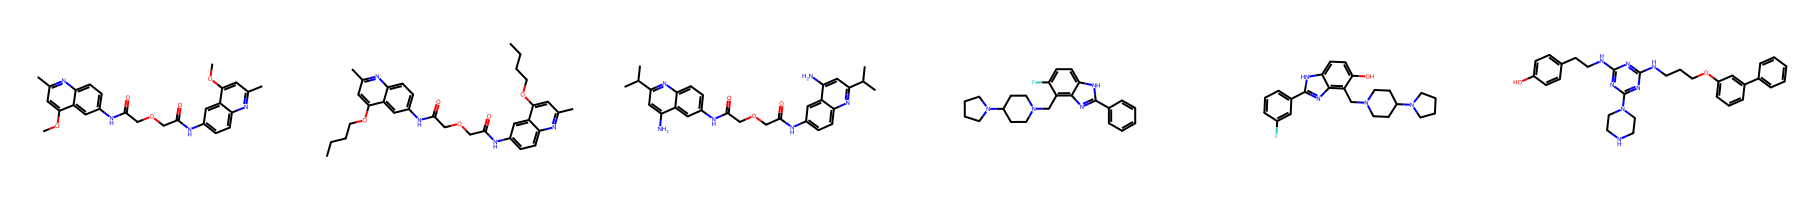

In [10]:
smiles_and_labels = pickle.load(open(f'{DATASET_DIR}/dd2_splits_smiles_and_labels.pkl', 'rb'))
# print(len(smiles_and_labels['test'][0]))
Draw.MolsToGridImage([MolFromSmiles(x) for x in smiles_and_labels['test'][0][:6]], molsPerRow=6, subImgSize=(300, 200))

Node IDx dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])
Node labels {0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'C', 6: 'C', 7: 'C', 8: 'C', 9: 'C', 10: 'N', 11: 'N', 12: 'C', 13: 'O', 14: 'C', 15: 'O', 16: 'C', 17: 'C', 18: 'O', 19: 'N', 20: 'C', 21: 'C', 22: 'C', 23: 'C', 24: 'C', 25: 'C', 26: 'N', 27: 'C', 28: 'C', 29: 'C', 30: 'C', 31: 'O', 32: 'C', 33: 'O', 34: 'C'}


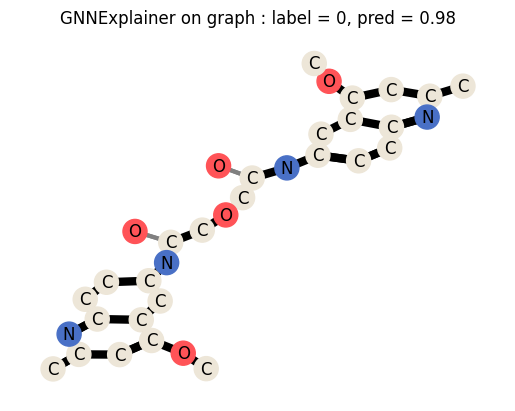

In [11]:
gnn_xp_module.visualize_explanation_for_graph(my_data=test_loader.dataset[0], threshold=0.5, device='cpu')

<h5 style="font-family: cursive">Interactive visualization of explanations</h5>

In [12]:
data=test_loader.dataset[:25]
gnn_xp_module.interactive_explanation_viz_for_graph(graphs=data)



### Interactive exploration of GNNExplainer explanations ###



interactive(children=(IntSlider(value=0, description='graph_idx', max=25), FloatSlider(value=0.5, description=…

<h5 style="font-family: cursive">Predicting via subgraphs</h5>

<p>Below, we will train and evaluate a logistic regression model built using fesatures(subgraphs) that were identified using the subgraph counting method. tThese features use these as features to predict the outcome. The features (subgraphs) can also be used to explain predictions, and we can see which are the most important ones.</p>
<p>This is a time and computation expensive process, since the time it takes to explicitly enumerate all subgraphs grows exponentially with k (max size of a subgraph). We will therefore limit the size of the training set to 1500.</p>



In [13]:
# %%time 
# subgraph_size=5


# ##Train model
# gnn_xp_module.train_subgraph_based_logreg_predictor(train_dataset[:1500], subgraph_size=subgraph_size)

# ## Evaluate model
# gnn_xp_module.evaluate_subgraph_based_logreg_predictor(test_dataset[:])


In [14]:
# gnn_xp_module.visualize_top_k_subgraphs(k=2)

In [15]:
print("\n", gcn_predictor.atom_featurizer.features_mapping)
print("\n", gcn_predictor.node_dict)


 {'atomic_num': {1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 15: 5, 16: 6, 17: 7, 35: 8, 53: 9, 'unk': 10}, 'n_valence': {0: 11, 1: 12, 2: 13, 3: 14, 4: 15, 5: 16, 6: 17, 'unk': 18}, 'n_hydrogens': {0: 19, 1: 20, 2: 21, 3: 22, 4: 23, 'unk': 24}, 'hybridization': {'s': 25, 'sp': 26, 'sp2': 27, 'sp3': 28, 'sp3d': 29, 'sp3d2': 30, 'unk': 31}, 'chiral_tag': {0: 32, 1: 33, 2: 34, 3: 35, 'unk': 36}, 'is_aromatic': {False: 37, True: 38, 'unk': 39}, 'is_in_ring': {False: 40, True: 41, 'unk': 42}, 'is_in_ring_size_4': {False: 43, True: 44, 'unk': 45}, 'is_in_ring_size_5': {False: 46, True: 47, 'unk': 48}, 'is_in_ring_size_6': {False: 49, True: 50, 'unk': 51}, 'atomic_mass': 52, 'atomic_vdw_radius': 53, 'atomic_covalent_radius': 54}

 {0: 'H', 1: 'C', 2: 'N', 3: 'O', 4: 'F', 5: 'P', 6: 'S', 7: 'Cl', 8: 'Br', 9: 'I', 10: 'unk'}


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]

Node IDx dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])
Node labels {0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'C', 6: 'C', 7: 'C', 8: 'C', 9: 'C', 10: 'N', 11: 'N', 12: 'C', 13: 'O', 14: 'C', 15: 'O', 16: 'C', 17: 'C', 18: 'O', 19: 'N', 20: 'C', 21: 'C', 22: 'C', 23: 'C', 24: 'C', 25: 'C', 26: 'N', 27: 'C', 28: 'C', 29: 'C', 30: 'C', 31: 'O', 32: 'C', 33: 'O', 34: 'C'}


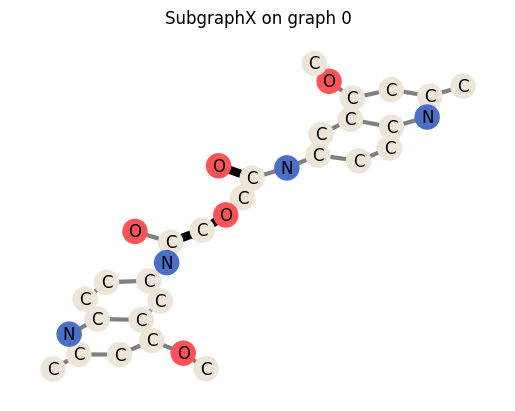

100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Node IDx dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])
Node labels {0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'O', 5: 'C', 6: 'C', 7: 'C', 8: 'C', 9: 'C', 10: 'C', 11: 'C', 12: 'N', 13: 'C', 14: 'C', 15: 'C', 16: 'N', 17: 'C', 18: 'O', 19: 'C', 20: 'O', 21: 'C', 22: 'C', 23: 'O', 24: 'N', 25: 'C', 26: 'C', 27: 'C', 28: 'C', 29: 'C', 30: 'C', 31: 'N', 32: 'C', 33: 'C', 34: 'C', 35: 'C', 36: 'O', 37: 'C', 38: 'C', 39: 'C', 40: 'C'}


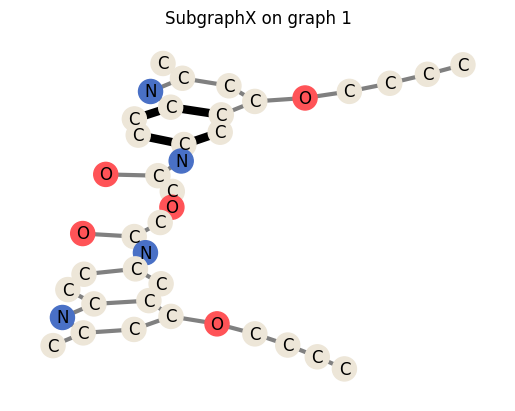

100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


Node IDx dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])
Node labels {0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'C', 6: 'N', 7: 'C', 8: 'C', 9: 'C', 10: 'N', 11: 'C', 12: 'O', 13: 'C', 14: 'O', 15: 'C', 16: 'C', 17: 'O', 18: 'N', 19: 'C', 20: 'C', 21: 'C', 22: 'C', 23: 'C', 24: 'C', 25: 'N', 26: 'C', 27: 'C', 28: 'C', 29: 'C', 30: 'O', 31: 'C', 32: 'C', 33: 'C', 34: 'C', 35: 'C', 36: 'C'}


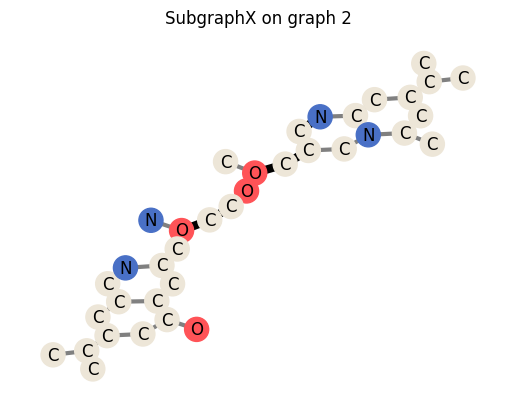

In [16]:
gnn_xp_module.visualize_subgraphx_explanations(dataset=test_loader.dataset[:3], device = 'cpu', num_nodes=10)